### Import Libraries

In [1]:
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions

warnings.filterwarnings("ignore")

### Import Dataset

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
len(df)

918

In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :', *categorical_features)
print('Numerical Features :', *numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


### Preprocessing

#### Categorical Encoding

In [6]:
le = LabelEncoder()

In [7]:
def encode(df, columns):
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

In [8]:
cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = encode(df, cols)

#### Feature Engineering

In [9]:
def standardScale(df, columns):
    for col in columns:
        df[col] = ss.fit_transform(df[[col]])
    return df

def minMaxScale(df, columns):
    for col in columns:
        df[col] = mms.fit_transform(df[[col]])
    return df

In [10]:
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

mms_cols = ['Oldpeak']
ss_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

df = minMaxScale(df, mms_cols)
df = standardScale(df, ss_cols)

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


#### Correlation with Heart Disease

Text(0.5, 1.0, 'Correlation w.r.t HeartDisease')

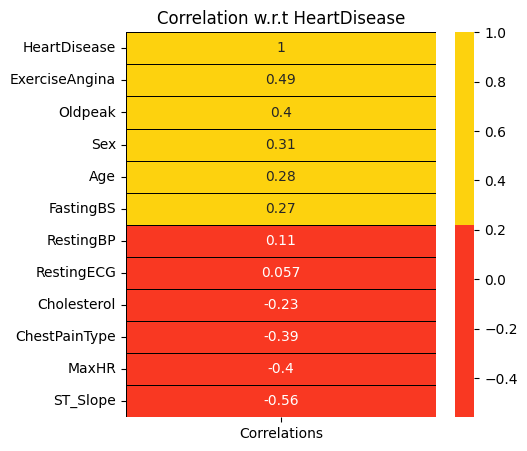

In [11]:
colors = ['#F93822','#FDD20E']
corr = df.corrwith(df['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t HeartDisease')

#### Feature selection for categorical features - Chi Squared Test

Text(0.5, 1.0, 'Selection of Categorical Features')

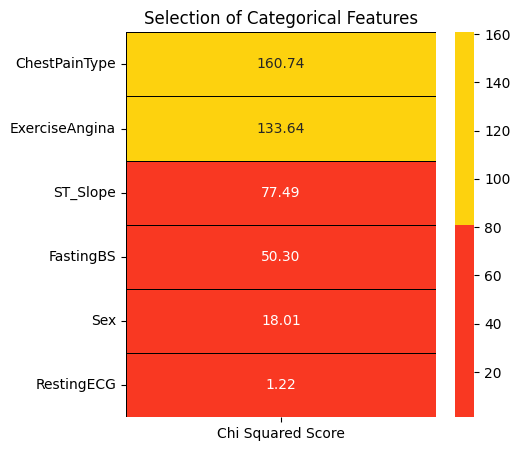

In [12]:
features = df.loc[:,categorical_features[:-1]]
target = df.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features')

#### Feature selection for categorical features - Anova Test

Text(0.5, 1.0, 'Selection of Numerical Features')

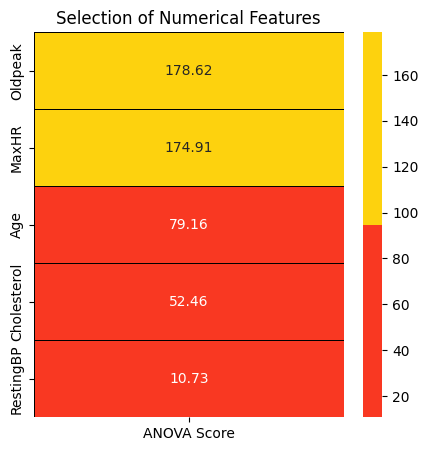

In [13]:
features = df.loc[:,numerical_features]
target = df.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features')

### Splitting into Training and Testing

In [14]:
features = df[df.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)

### Model Creation

#### Logistic Regression

In [15]:
lr = LogisticRegression(
    random_state=0,
    C=10,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
)

#### Support Vector Machine

In [16]:
svc = SVC(
    kernel='linear',
    C=1.0,
    gamma='scale',
    class_weight=None,
    random_state=42,
    decision_function_shape='ovr',
    max_iter=-1,
)

#### Random Forest

In [17]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=0
)

### Train the Models

In [18]:
def trainModel(model):
    model.fit(x_train, y_train)

In [19]:
trainModel(lr)

In [20]:
trainModel(svc)

In [21]:
trainModel(rf)

### Evaluate the Models

In [22]:
def evaluateModel(model, model_name):
    pred = model.predict(x_test)
    print(f"{'='*10} {model_name} {'='*10}")
    print("Accuracy: {:.2%}".format(accuracy_score(y_test, pred)))
    print("ROC_AUC Score: {:.2%}".format(roc_auc_score(y_test, pred)))

    # Plot ROC Curve
    RocCurveDisplay.from_estimator(model, x_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

    # Confusion Matrix with Seaborn Heatmap
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print(classification_report(y_test, pred))

========== Logistic Regression ==========
Accuracy: 87.50%
ROC_AUC Score: 87.43%


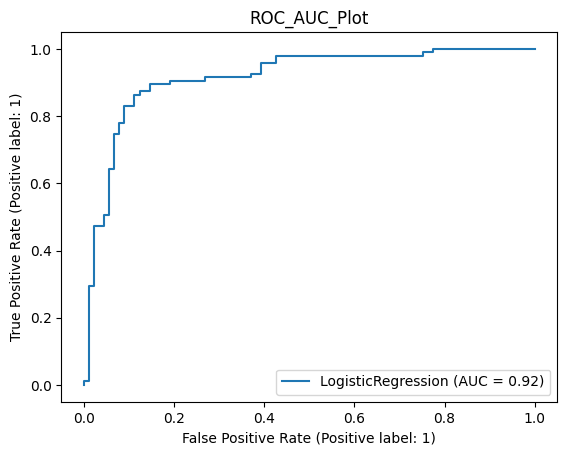

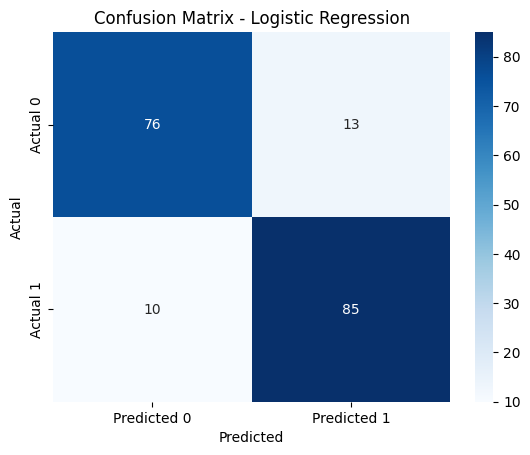

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



In [23]:
evaluateModel(lr, 'Logistic Regression')

========== Support Vector Machine ==========
Accuracy: 86.41%
ROC_AUC Score: 86.35%


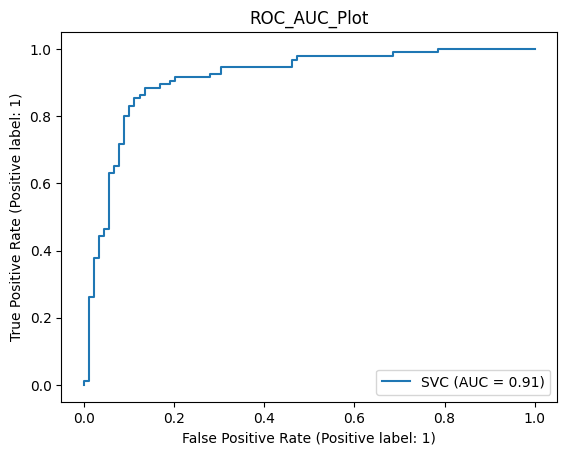

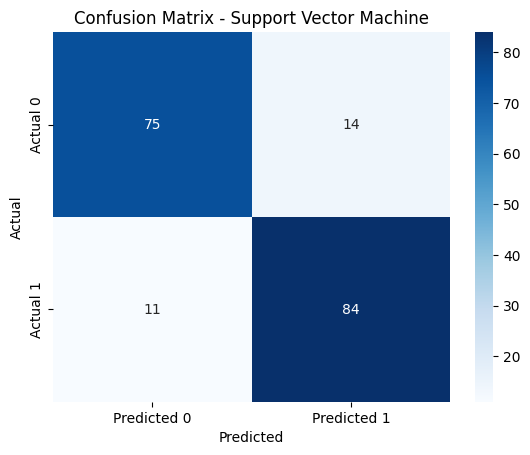

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        89
           1       0.86      0.88      0.87        95

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [24]:
evaluateModel(svc, 'Support Vector Machine')

========== Random Forest ==========
Accuracy: 84.24%
ROC_AUC Score: 84.06%


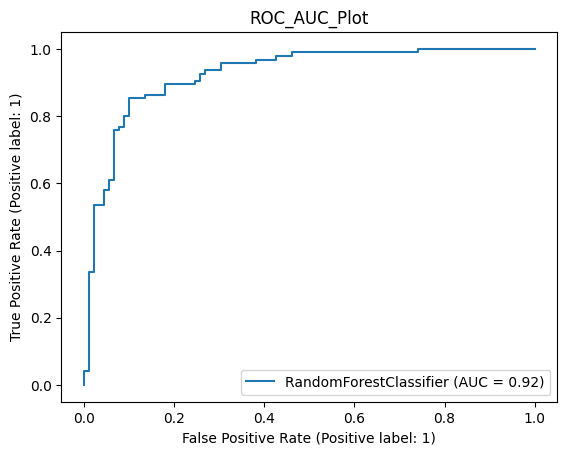

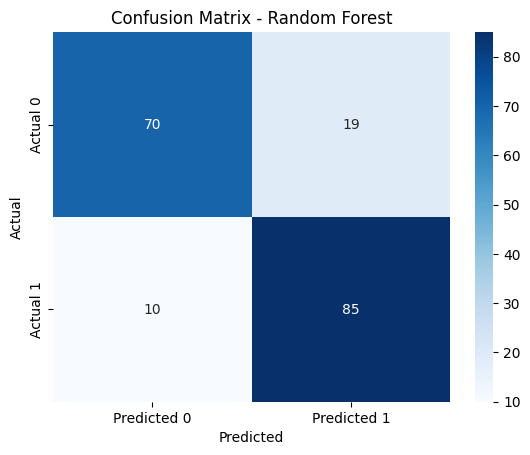

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        89
           1       0.82      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



In [25]:
evaluateModel(rf, 'Random Forest')